In [1]:
import numpy as np

In [2]:
# 0.1 midi mappings from groove dataset
# kick drum
BASS = 36
# snare drum
SNARE_HEAD = 38
SNARE_RIM = 40
SNARE_X_STICK = 37
# toms
TOM_1_HEAD = 48
TOM_1_RIM = 50
TOM_2_HEAD = 45
TOM_2_RIM = 47
TOM_3_HEAD = 43
TOM_3_RIM = 58
# hi-hats
HH_OPEN_BOW = 46
HH_OPEN_EDGE = 26
HH_CLOSED_BOW = 42
HH_CLOSED_EDGE = 22
HH_PEDAL = 44
# crash cymbal
CRASH_1_BOW = 49
CRASH_1_EDGE = 55
CRASH_2_BOW = 57
CRASH_2_EDGE = 52
# ride cymbal
RIDE_BOW = 51
RIDE_EDGE = 59
RIDE_BELL = 53

# mappings for our own training (9)
KICK = 0
SNARE = 1
HH_CLOSED = 2
HH_OPEN = 3
RIDE = 4
TOM_1 = 5
TOM_2 = 6
TOM_3 = 7
CRASH = 8
NUM_FEATS = 9

# groove mappings to our mappings
KICK_LIST = [BASS]
SNARE_LIST = [SNARE_HEAD, SNARE_RIM, SNARE_X_STICK]
HH_CLOSED_LIST = [HH_CLOSED_BOW, HH_CLOSED_EDGE, HH_PEDAL]
HH_OPEN_LIST = [HH_OPEN_BOW, HH_OPEN_EDGE]
RIDE_LIST = [RIDE_BOW, RIDE_EDGE, RIDE_BELL]
TOM_1_LIST = [TOM_1_HEAD, TOM_1_RIM]
TOM_2_LIST = [TOM_2_HEAD, TOM_2_RIM]
TOM_3_LIST = [TOM_3_HEAD, TOM_3_RIM]
CRASH_LIST = [CRASH_1_BOW, CRASH_1_EDGE, CRASH_2_BOW, CRASH_2_EDGE]

In [3]:
# loss and optimizer

import tensorflow as tf

def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1
  
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost.
    Average (1 - soft-F1) across all labels.
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [4]:
# 1.1 code to convert midi file to array
# https://medium.com/analytics-vidhya/convert-midi-file-to-numpy-array-in-python-7d00531890c

import string

def msg2dict(msg):
    result = dict()
    if 'note_on' in msg:
        on_ = True
    elif 'note_off' in msg:
        on_ = False
    else:
        on_ = None
    result['time'] = int(msg[msg.rfind('time'):].split(' ')[0].split('=')[1].translate(
        str.maketrans({a: None for a in string.punctuation})))

    if on_ is not None:
        for k in ['note', 'velocity']:
            result[k] = int(msg[msg.rfind(k):].split(' ')[0].split('=')[1].translate(
                str.maketrans({a: None for a in string.punctuation})))
    return [result, on_]

def switch_note(last_state, note, velocity, on_=True):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of this range will be ignored
    result = [0] * 88 if last_state is None else last_state.copy()
    if 21 <= note <= 108:
        value = 1 if velocity > 0 else 0
        result[note-21] = value if on_ else 0
    return result

def get_new_state(new_msg, last_state):
    new_msg, on_ = msg2dict(str(new_msg))
    new_state = switch_note(last_state, note=new_msg['note'], velocity=new_msg['velocity'], on_=on_) if on_ is not None else last_state
    return [new_state, new_msg['time']]

def track2seq(track):
    # piano has 88 notes, corresponding to note id 21 to 108, any note out of the id range will be ignored
    result = []
    last_state, last_time = get_new_state(str(track[0]), [0]*88)
    for i in range(1, len(track)):
        new_state, new_time = get_new_state(track[i], last_state)
        if new_time > 0:
            result += [last_state]*new_time
        last_state, last_time = new_state, new_time
    return result

def mid2array(mid, min_msg_pct=0.1):
    tracks_len = [len(tr) for tr in mid.tracks]
    min_n_msg = max(tracks_len) * min_msg_pct
    # convert each track to nested list
    all_arys = []
    for i in range(len(mid.tracks)):
        if len(mid.tracks[i]) > min_n_msg:
            ary_i = track2seq(mid.tracks[i])
            all_arys.append(ary_i)
    # make all nested list the same length
    max_len = max([len(ary) for ary in all_arys])
    for i in range(len(all_arys)):
        if len(all_arys[i]) < max_len:
            all_arys[i] += [[0] * 88] * (max_len - len(all_arys[i]))
    all_arys = np.array(all_arys)
    all_arys = all_arys.max(axis=0)
    # trim: remove consecutive 0s in the beginning and at the end
    # sums = all_arys.sum(axis=1)
    # ends = np.where(sums > 0)[0]
    return all_arys #[min(ends): max(ends)]

# reformats midi array for training
def reformat_midi(midi_array):
    midi_array = midi_array.T # transpose midi array for easy access
    T_steps = midi_array.shape[1] # get number of time steps
    # kicks
    kick_midi = np.zeros((T_steps), dtype='int64')
    for val in KICK_LIST:
        kick_midi += midi_array[val-21]
    kick_midi = np.where(kick_midi > 0, 1, 0)
    # snares
    snare_midi = np.zeros((T_steps), dtype='int64')
    for val in SNARE_LIST:
        snare_midi += midi_array[val-21]
    snare_midi = np.where(snare_midi > 0, 1, 0)
    # hh_close
    hh_close_midi = np.zeros((T_steps), dtype='int64')
    for val in HH_CLOSED_LIST:
        hh_close_midi += midi_array[val-21]
    hh_close_midi = np.where(hh_close_midi > 0, 1, 0)
    # hh_open
    hh_open_midi = np.zeros((T_steps), dtype='int64')
    for val in HH_OPEN_LIST:
        hh_open_midi += midi_array[val-21]
    hh_open_midi = np.where(hh_open_midi > 0, 1, 0)
    # ride
    ride_midi = np.zeros((T_steps), dtype='int64')
    for val in RIDE_LIST:
        ride_midi += midi_array[val-21]
    ride_midi = np.where(ride_midi > 0, 1, 0)
    # tom 1
    tom1_midi = np.zeros((T_steps), dtype='int64')
    for val in TOM_1_LIST:
        tom1_midi += midi_array[val-21]
    tom1_midi = np.where(tom1_midi > 0, 1, 0)
    # tom 2
    tom2_midi = np.zeros((T_steps), dtype='int64')
    for val in TOM_2_LIST:
        tom2_midi += midi_array[val-21]
    tom2_midi = np.where(tom2_midi > 0, 1, 0)
    # tom 3
    tom3_midi = np.zeros((T_steps), dtype='int64')
    for val in TOM_3_LIST:
        tom3_midi += midi_array[val-21]
    tom3_midi = np.where(tom3_midi > 0, 1, 0)
    # crash
    crash_midi = np.zeros((T_steps), dtype='int64')
    for val in CRASH_LIST:
        crash_midi += midi_array[val-21]
    crash_midi = np.where(crash_midi > 0, 1, 0)
    
    reformated_midi_array = np.zeros((midi_array.shape[1], NUM_FEATS), dtype='int64')
    reformated_midi_array[:,KICK] = kick_midi
    reformated_midi_array[:,SNARE] = snare_midi
    reformated_midi_array[:,HH_CLOSED] = hh_close_midi
    reformated_midi_array[:,HH_OPEN] = hh_open_midi
    reformated_midi_array[:,RIDE] = ride_midi
    reformated_midi_array[:,TOM_1] = tom1_midi
    reformated_midi_array[:,TOM_2] = tom2_midi
    reformated_midi_array[:,TOM_3] = tom3_midi
    reformated_midi_array[:,CRASH] = crash_midi
    return reformated_midi_array

In [5]:
# load in model

from tensorflow import keras

MODEL_ID = 'model_64x64'

model = keras.models.load_model('models/' + MODEL_ID, custom_objects={'macro_soft_f1':macro_soft_f1, 'macro_f1':macro_f1})

In [6]:
# load in wav file and convert to data for model

import numpy as np
import audiosegment
import matplotlib.pyplot as plot
import librosa
from scipy import signal

SEGMENT_LEN = 0.05 # length of each segment in seconds
WINDOW_LEN = SEGMENT_LEN / 32
OVERLAP = 0.25

def show_midi_plot(midi_array):
    midi_array = np.flip(midi_array.T, axis=0)
    f = plot.figure()
    f.set_figwidth(20)
    f.set_figheight(10)
    plot.imshow(midi_array, cmap='binary', interpolation='None', aspect="auto")
    plot.show()

def remove_leading_silence(wav_array):
    leading_silence = 0
    for t in range(len(wav_array)):
        if wav_array[t] == 0 or wav_array[t] == -1 or wav_array[t] == 1:
            leading_silence += 1
        else:
            break
    if leading_silence > 0:
        wav_array = wav_array[leading_silence:]
    return wav_array

def convert_wav_to_data(audio_file_path, segment_length, window_length, overlap, print_out=False):
    # load in wav file
    wav_file = audiosegment.from_file(audio_file_path)
    if print_out:
        print ('wav file duration: ', wav_file.duration_seconds, ' framerate: ', wav_file.frame_rate)
    # convert sample width if not set to 2 (16 bits)
    if wav_file.sample_width != 2:
        wav_file = wav_file.set_sample_width(2)
        # print("\tnew sample_width: ", wav_file.sample_width)
        wav_file.export(audio_file_path, format="wav")
    # convert file from stereo to mono if channels > 1
    if wav_file.channels != 1:
        wav_file = wav_file.set_channels(1)
        wav_file.export(audio_file_path, format="wav")
    # remove starting silence from wav file
    wav_array = wav_file.to_numpy_array()
    wav_array = remove_leading_silence(wav_array)
    wav_file = audiosegment.from_numpy_array(wav_array, framerate=wav_file.frame_rate)
    if print_out:
        print ('new wav file duration: ', wav_file.duration_seconds)
    
    # show wav file spec
    if print_out:
        freqs, times, amps = wav_file.spectrogram(window_length_s=window_length, overlap=overlap)
        amps = 10 * np.log10(amps + 1e-9)
        plot.pcolormesh(times, freqs, amps)
        plot.xlabel("Time in Seconds")
        plot.ylabel("Frequency in Hz")
        plot.show()
    
    diced_wav_file = wav_file.dice(segment_length, zero_pad=True)
    
    # apply mel filer to audio segments
    formated_audio = []
    for seg in diced_wav_file:
        seg_np = seg.to_numpy_array()
        seg_np = seg_np - seg_np.mean()
        seg_np = np.append(seg_np[0],seg_np[1:]-.97*seg_np[:-1])
        
        #print ('seg_np.shape: ', seg_np.shape)
        
        n_fft = 2048
        
        # compute mel spectrogram
        stft = librosa.stft(seg_np, n_fft=n_fft, hop_length=69, win_length=256, window=signal.hamming)
        spec = np.abs(stft)**2
        
        #print ('spec.shape: ', spec.shape)
        
        mel_basis = librosa.filters.mel(sr=44100, n_fft=n_fft, n_mels=64, fmin=0, fmax=20000)
        melspec = np.dot(mel_basis, spec)
        logspec = librosa.power_to_db(melspec, ref=np.max)
        logspec = np.transpose(logspec)
        
        #print ('logspec.shape: ', logspec.shape)
        
        # if print_out:
        #     plot.imshow(logspec, origin='lower', aspect='auto')
        #     plot.show()

        formated_audio.append(logspec)
    formated_audio_array = np.array(formated_audio, dtype='float32')
    
    if print_out:
        print ('formated_audio_array.shape: ', formated_audio_array.shape)
    
    # reshape into frames
    framed_audio_list = []
    final_element_index = int(formated_audio_array.shape[0] - 1)
    for i, seg in enumerate(formated_audio_array):
        frames = []
        if i == 0:
            frames.append(formated_audio_array[0])
            frames.append(formated_audio_array[1])
            frames.append(formated_audio_array[2])
        elif i == final_element_index:
            frames.append(formated_audio_array[final_element_index - 2])
            frames.append(formated_audio_array[final_element_index - 1])
            frames.append(formated_audio_array[final_element_index])
        else:
            frames.append(formated_audio_array[i-1])
            frames.append(formated_audio_array[i])
            frames.append(formated_audio_array[i+1])
        
        frames_np = np.array(frames, dtype='float32')
        framed_audio_list.append(frames_np)
            
    framed_audio_array = np.array(framed_audio_list, dtype='float32')
    
    if print_out:
        print ('framed_audio_array.shape: ', framed_audio_array.shape)
    return framed_audio_array

c:\Users\Marco\AppData\Local\Programs\Python\Python310\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [ ]:
from ipynb.fs.full.convert_to_midi import convert_array_to_midi
import mido

audio_file = '17_jazz-funk_116_fill_4-4'
midi_file_path = 'data/groove/drummer1/session1/' + audio_file + '.mid'
midi = mido.MidiFile(midi_file_path)
midi_array = mid2array(midi)
midi_array = reformat_midi(midi_array)
calculated_length = mido.tick2second(midi_array.shape[0], ticks_per_beat=midi.ticks_per_beat, tempo=mido.bpm2tempo(120))
midi_file = convert_array_to_midi(midi_array, calculated_length)
midi_file.save("data/midi/midi" + audio_file + ".mid")

data.shape:  (40, 3, 64, 64, 1)
2/2 [==============================] - 0s 30ms/step
prediction.shape:  (40, 9)
real midi:


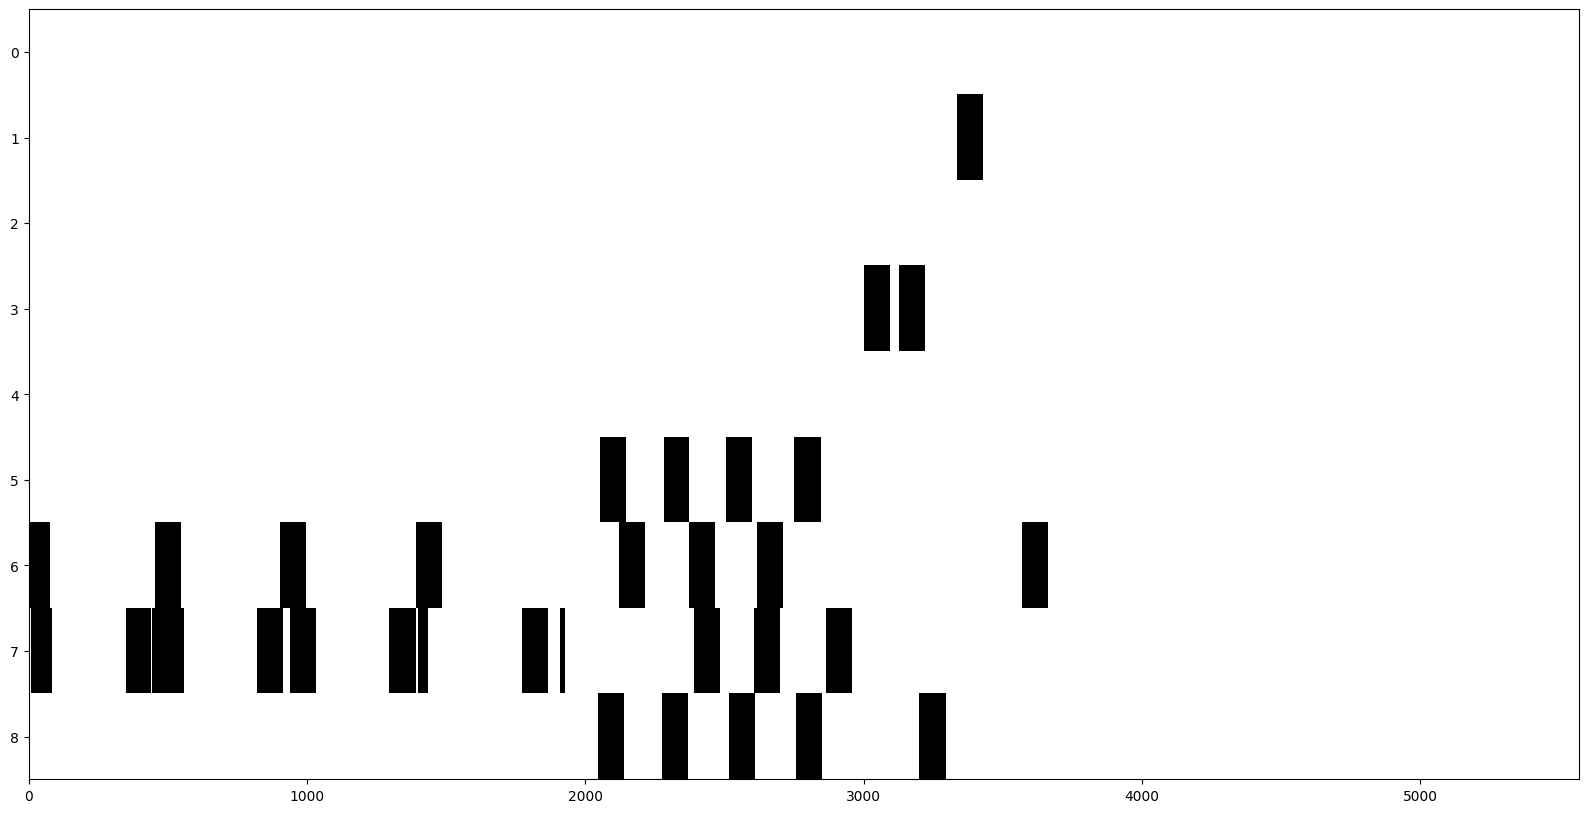

predicted midi:


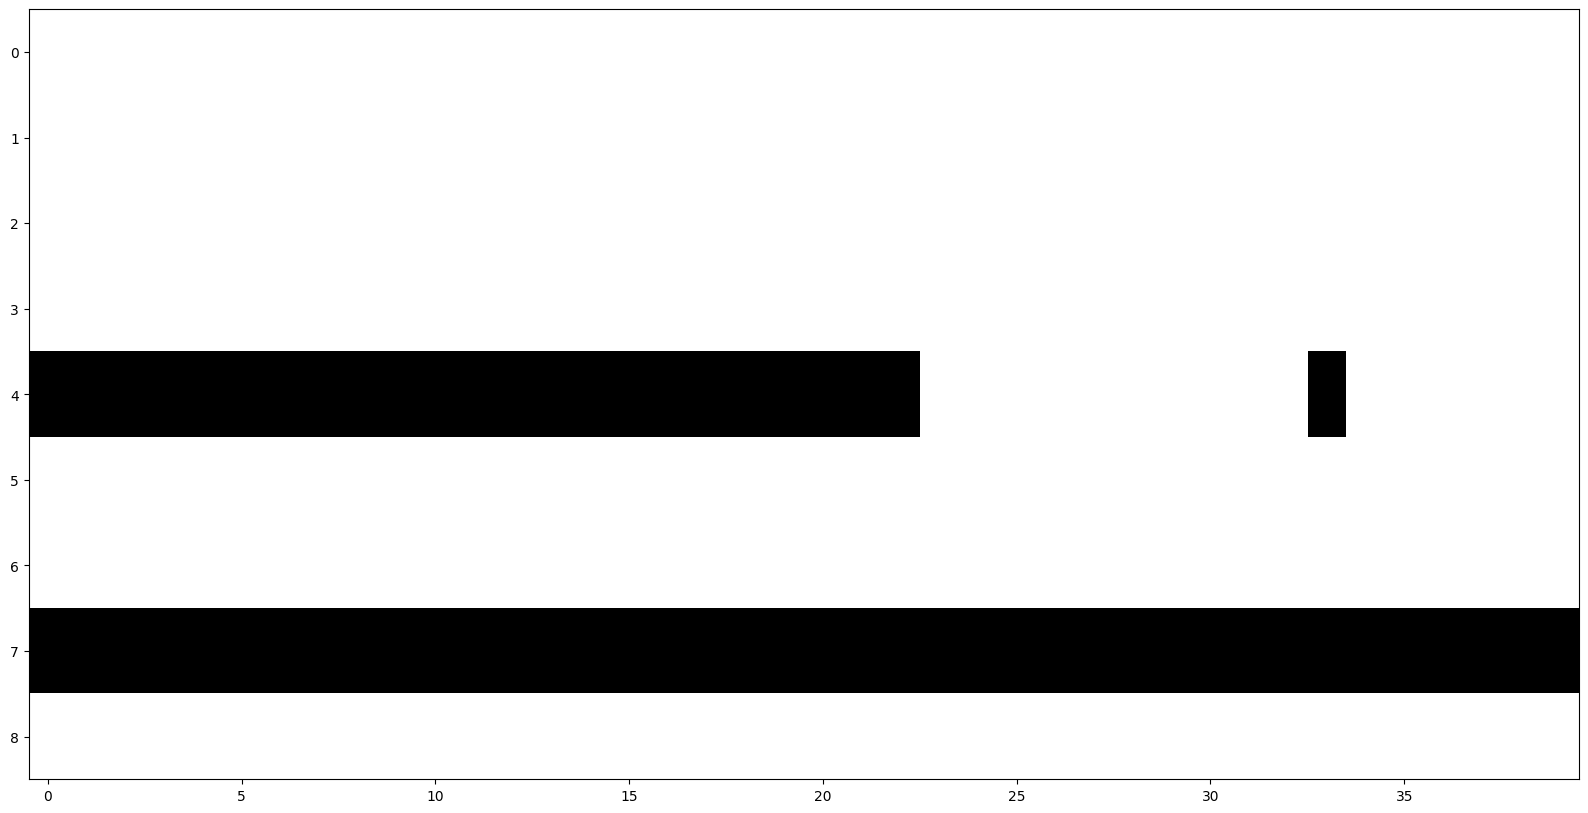

length_seconds:  4.0


In [8]:
from ipynb.fs.full.convert_to_midi import convert_array_to_midi
import mido

np.set_printoptions(suppress=True)

SEGMENT_LEN = 0.1 # length of each segment in seconds
WINDOW_LEN = SEGMENT_LEN / 35
OVERLAP = 0.5

audio_file = '17_jazz-funk_116_fill_4-4'
audio_file_path = 'data/groove/drummer1/session1/' + audio_file + '.wav'
midi_file_path = 'data/groove/drummer1/session1/' + audio_file + '.mid'
data = convert_wav_to_data(audio_file_path, segment_length=SEGMENT_LEN, window_length=WINDOW_LEN, overlap=OVERLAP, print_out=False)

data = data.reshape(data.shape[0], data.shape[1], data.shape[2], data.shape[3], 1)
print ('data.shape: ', data.shape)

prediction = model.predict(data)

print ('prediction.shape: ', prediction.shape)
#print ('prediction: ', prediction)

# convert predictions to array of 0s and 1s
prediction = np.where(prediction > 0.95, 1, 0)

midi = mido.MidiFile(midi_file_path)
midi_array = mid2array(midi)
midi_array = reformat_midi(midi_array)
print ('real midi:')
show_midi_plot(midi_array)
print ('predicted midi:')
show_midi_plot(prediction)

length_seconds = SEGMENT_LEN * prediction.shape[0]
print ('length_seconds: ', length_seconds)
midi_file = convert_array_to_midi(prediction, length_seconds)
midi_file.save("data/midi/midi" + audio_file + ".mid")